In [16]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from pykalman import KalmanFilter
from numba import guvectorize
from scipy import signal
from scipy import stats as ss
import mpld3
from datetime import timedelta

In [17]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit = 0

In [18]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

In [19]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=EOS_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_EOS', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [20]:
df = get_ohlcv_poloniex(pair='USDT_EOS', start=1483600958, end=9999999999, period=900)
#no option to pass in 3600 sec candles
df = df[df.index % 4 == 0]
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']
df['logVolume'] = df['volume'].apply(np.log)

In [22]:
df = df.tail(1000)

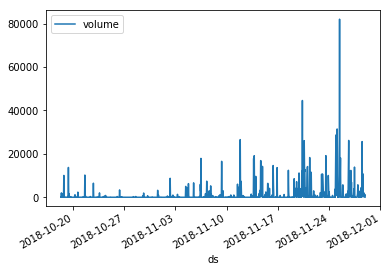

In [23]:
df.plot(x='ds', y ='volume')


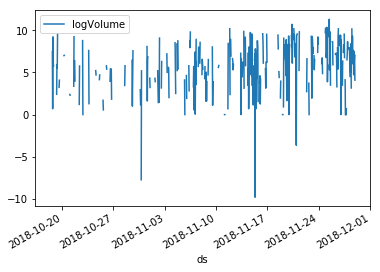

In [24]:
df.plot(x='ds', y ='logVolume')

# Start of Prophet Work

In [25]:
prophet = Prophet(seasonality_mode='multiplicative')
prophet.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [26]:
df.y.kurtosis()
#The kurtosis is less than 3, which means there are very few outliers than there are in a normal distribution

-0.3362573592537976

In [27]:
df.y.skew()
#The skew is positive, which means that that the the graph is asymmetric, 
#with a longer right tail and the mass on the left side.

-1.0792575928079302

# Creating Future and Forecast with 30 periods, then the volume is plotted with prophet

In [28]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=30)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1025 2018-12-24 22:45:00  0.178850   -7.989170    7.150576
1026 2018-12-25 22:45:00  0.069920   -8.442701    7.370568
1027 2018-12-26 22:45:00 -0.039805   -9.039356    7.701137
1028 2018-12-27 22:45:00 -0.148549   -9.611422    7.906709
1029 2018-12-28 22:45:00 -0.257535  -10.183526    8.107037

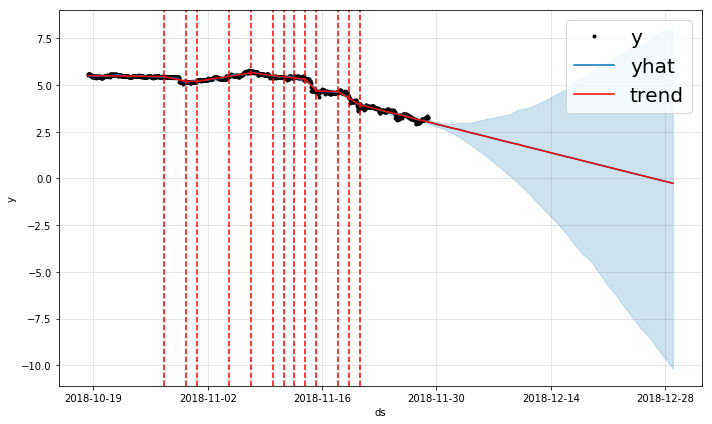

In [29]:
#Build the plot to show the forecasted data
bc_Volume = prophet.plot(forecast)
a = add_changepoints_to_plot(bc_Volume.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)


# Daily Forecasts by plotting prophet components future uncertainty

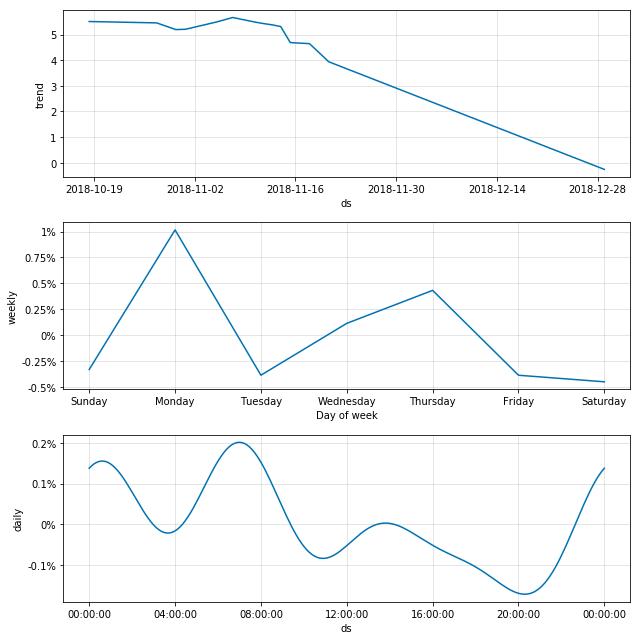

In [30]:
fig2 = prophet.plot_components(forecast,uncertainty=False)

# Build the prophet graph of volume data with a changepoint scale of .5; this makes the plotting more flexible

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


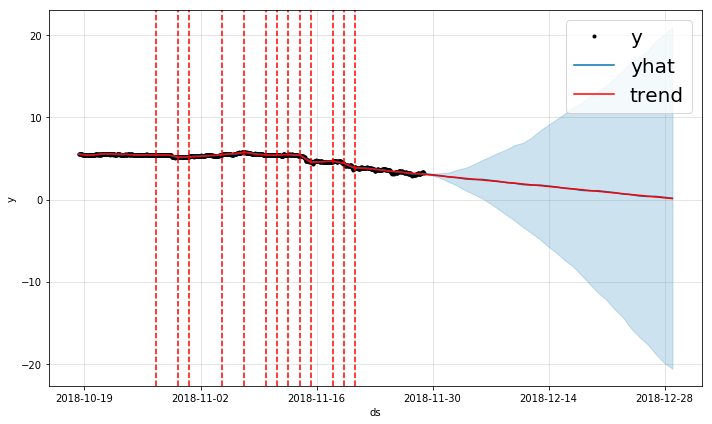

In [31]:
#Making the plotting more flexible (Alters the graph quite a bit, actually trends upwards instead of down)
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)


In [32]:
bc_Volume_Logistic = Prophet(growth = 'logistic')
bc_Volume_Logistic.fit(df)
future_logistic = bc_Volume_Logistic.make_future_dataframe(periods=30)
future_logistic['cap'] = 2500
future_logistic['floor'] = 20000
fcst_logistic = bc_Volume_Logistic.predict(future_logistic)
fig_logistic = bc_Volume_Logistic.plot(fcst_logistic)
plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
ValueError: Capacities must be supplied for logistic growth in column 'cap'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ValueError: Capacities must be supplied for logistic growth in column 'cap'

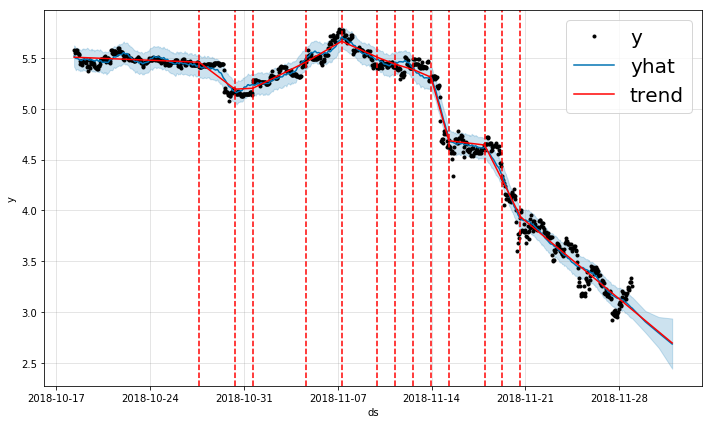

In [34]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=3)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Build the plot to show the forecasted data
bc_Volume = prophet.plot(forecast)
a = add_changepoints_to_plot(bc_Volume.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)

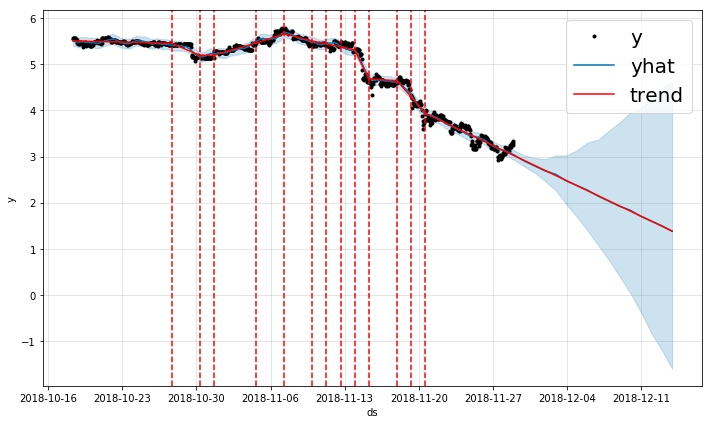

In [35]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=15)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Build the plot to show the forecasted data
bc_Volume = prophet.plot(forecast)
a = add_changepoints_to_plot(bc_Volume.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)

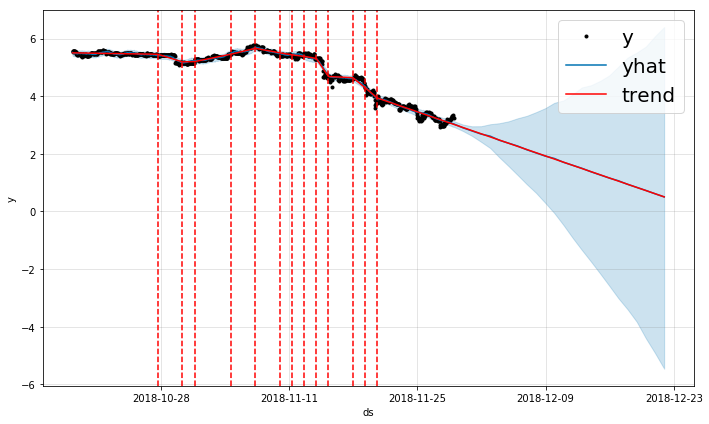

In [36]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=23)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Build the plot to show the forecasted data
bc_Volume = prophet.plot(forecast)
a = add_changepoints_to_plot(bc_Volume.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)

# KCA Analysis

In [37]:
def fitKCA(t,z,q,fwd=0):
    #Set up Matrices
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],[0,1,h],[0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter    
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth 
    x_mean,x_covar=kf.smooth(z)
    #Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                    filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [38]:
x_mean, x_std, x_covar = fitKCA(df.date.values,df.volume.values,1)

In [39]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [40]:
def v_a(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    x_mean,x_std,x_covar=fitKCA(df.date.values, df.y.values, .1) 
    
    df['velocity'] = x_mean[:,1]
    df['acceleration'] = x_mean[:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    p_df = df[['ds', 'velocity', 'acceleration']].copy()

    p_df['y'] = p_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    p_df['y'] = p_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

In [41]:
def run(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    
    df['velocity'] = result[0][:,1]
    df['acceleration'] = result[0][:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    prophet_df = df[['ds', 'velocity', 'acceleration']].copy()

    prophet_df['y'] = prophet_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    prophet_df['y'] = prophet_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

count    1.000000e+03
mean    -4.265762e-07
std      1.360136e-05
min     -9.290050e-05
25%     -4.700620e-06
50%     -1.895512e-09
75%      3.960666e-06
max      1.829098e-04
Name: velocity, dtype: float64
count    1.000000e+03
mean    -5.298200e-11
std      2.613245e-09
min     -3.325271e-08
25%     -1.054391e-09
50%     -1.082179e-12
75%      8.861103e-10
max      1.446714e-08
Name: acceleration, dtype: float64


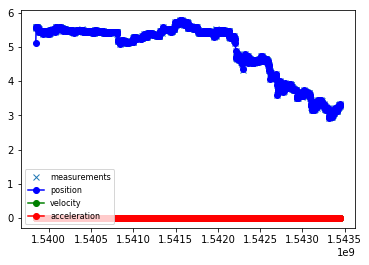

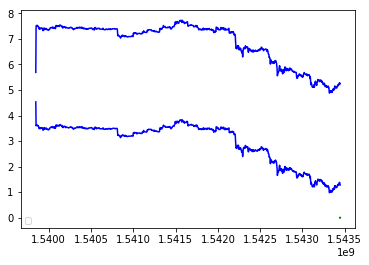

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


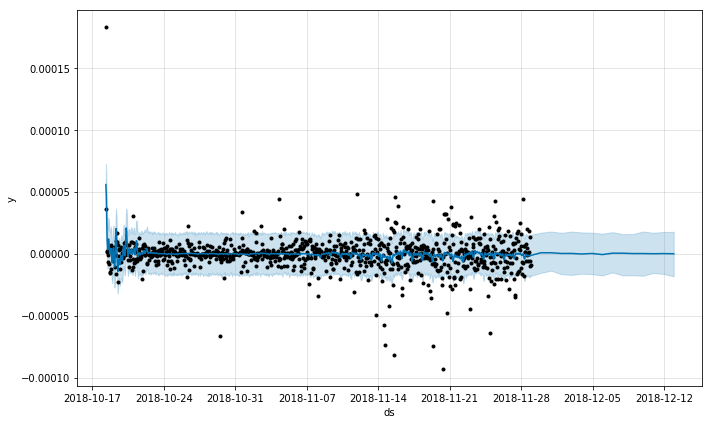

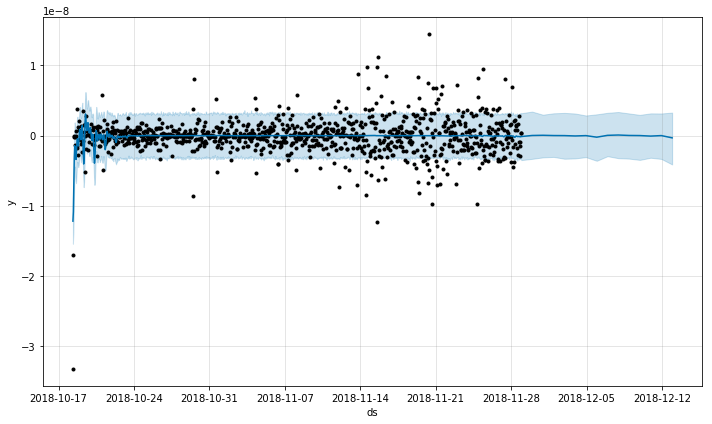

In [42]:
v_a(df)

(2018, 10)
count    3.290000e+02
mean     4.468091e-07
std      1.281853e-05
min     -6.718937e-05
25%     -2.041387e-06
50%     -4.889304e-09
75%      2.663521e-06
max      1.868280e-04
Name: velocity, dtype: float64
count    3.290000e+02
mean    -1.422528e-10
std      2.545515e-09
min     -3.411183e-08
25%     -6.579685e-10
50%     -9.641996e-13
75%      6.443494e-10
max      8.232217e-09
Name: acceleration, dtype: float64


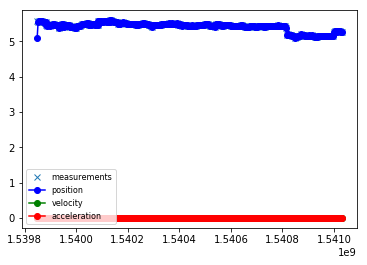

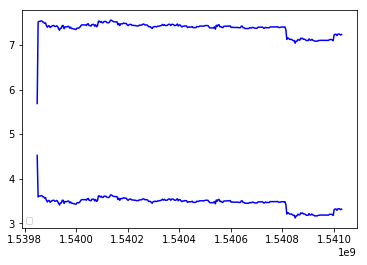

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


(2018, 11)
count    6.710000e+02
mean    -5.160235e-07
std      1.627492e-05
min     -9.556904e-05
25%     -5.989478e-06
50%     -6.507121e-08
75%      5.341870e-06
max      1.866801e-04
Name: velocity, dtype: float64
count    6.710000e+02
mean    -7.647575e-11
std      3.317783e-09
min     -3.511717e-08
25%     -1.557913e-09
50%      1.776948e-12
75%      1.390554e-09
max      1.575324e-08
Name: acceleration, dtype: float64


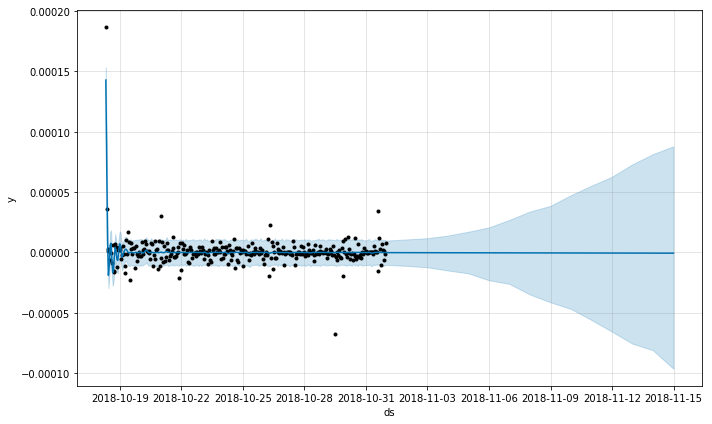

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
ValueError: view limit minimum -76398420.41093749 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


ValueError: view limit minimum -76398420.41093749 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

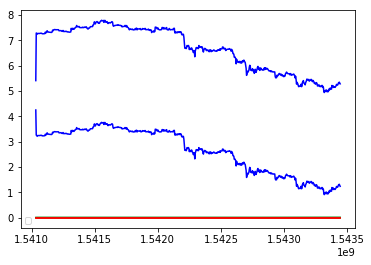

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


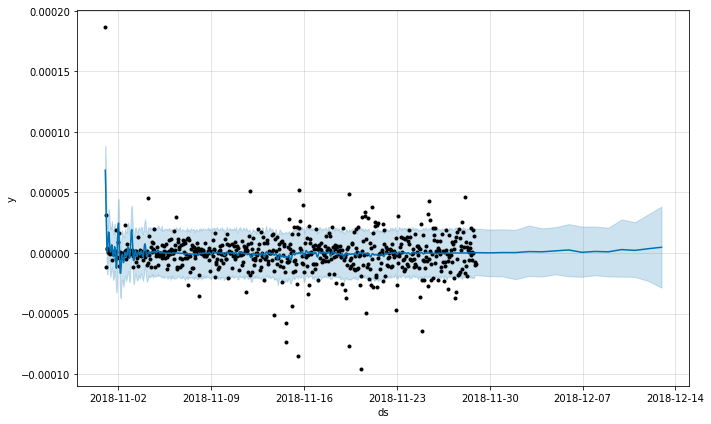

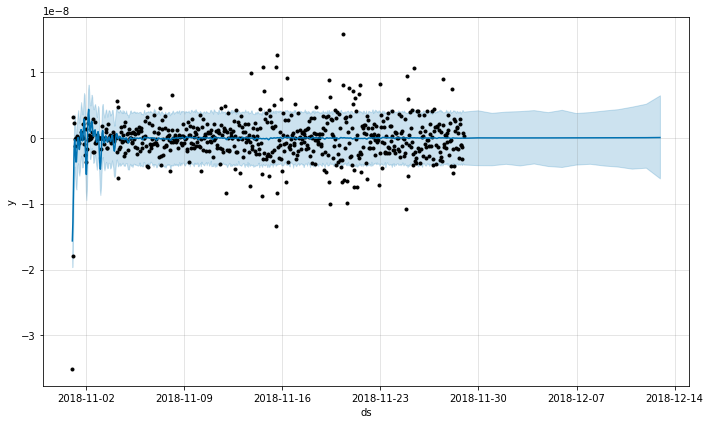

In [43]:
#monthly
d = dict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items():
    print(i)
    run(df_month)

Text(0.5,1,'Position')

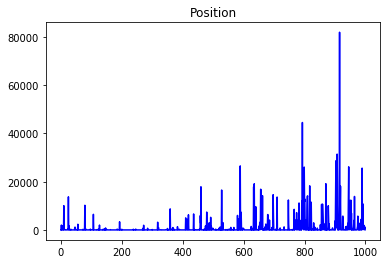

In [44]:
#position
mpld3.enable_notebook()
plt.plot(x_mean[:,0],color='blue') 
plt.title('Position')

Text(0.5,1,'Velocity')

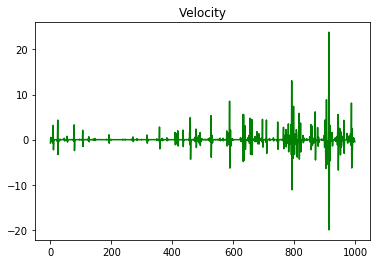

In [45]:
#velocity
plt.plot(x_mean[:,1],color='green') 
plt.title('Velocity')

Text(0.5,1,'Acceleration')

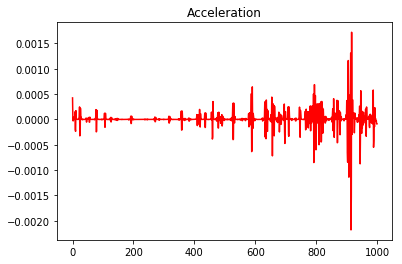

In [46]:
#acceleration
plt.plot(x_mean[:,2],color='red')
plt.title('Acceleration')

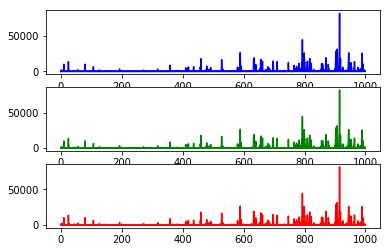

In [47]:
fig, axes = plt.subplots(nrows=3)

colors = ('b', 'g', 'r')
for ax, color in zip(axes, colors):
    #data = np.random.random(1) * np.random.random(10)
    ax.plot(x_mean[:,0],color=color)
    ax.plot(x_mean[:,1],color=color)
    ax.plot(x_mean[:,2],color=color)
    #ax.plot(data, marker='o', linestyle='none', color=color)
plt.rcParams['figure.figsize'] = [15,15]
plt.show()

Text(0.5,1,'Velocity')

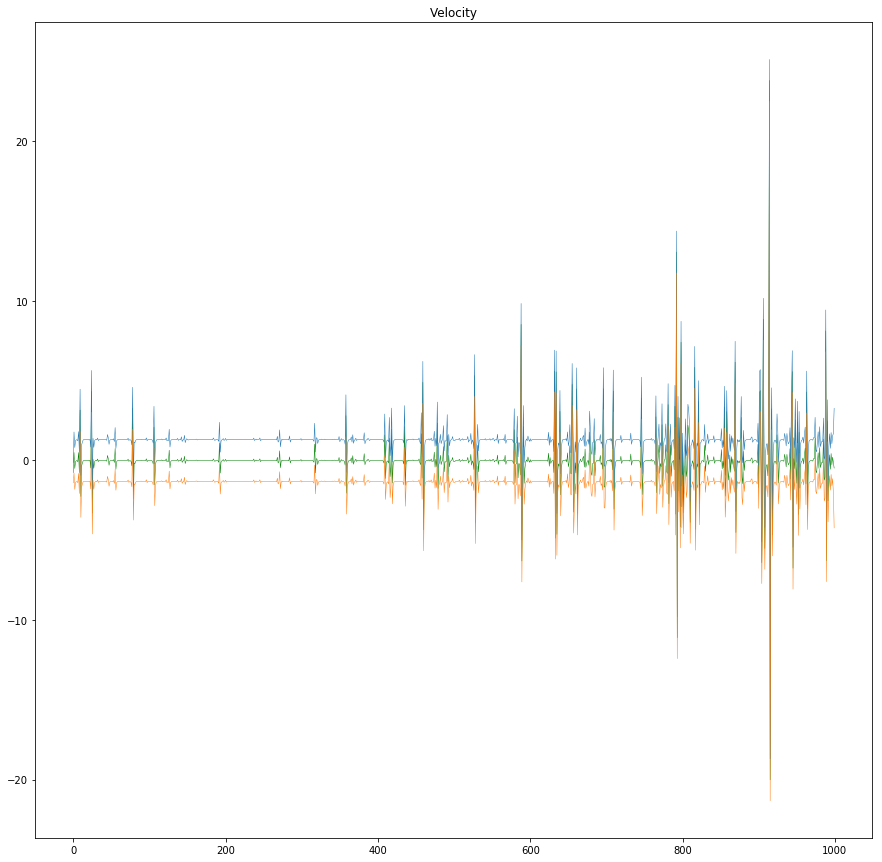

In [48]:
#velocity

upper_error_bars = x_mean[:,1] + x_std[:,1]
lower_error_bars = x_mean[:,1] - x_std[:,1]

plt.plot(x_mean[:,1],color='green',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)
plt.rcParams['figure.figsize'] = [6,6]
plt.title('Velocity')

Inertia

In [49]:
prophet = Prophet(seasonality_mode='multiplicative')
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = x_mean[:,1]

In [50]:
prophet.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [51]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=180)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1175 2019-05-23 22:45:00  0.018179   -2.171278    2.050265
1176 2019-05-24 22:45:00  0.018264   -2.182175    2.206412
1177 2019-05-25 22:45:00  0.018359   -2.110091    2.093878
1178 2019-05-26 22:45:00  0.018446   -2.054013    2.236475
1179 2019-05-27 22:45:00  0.018540   -2.182721    1.914103

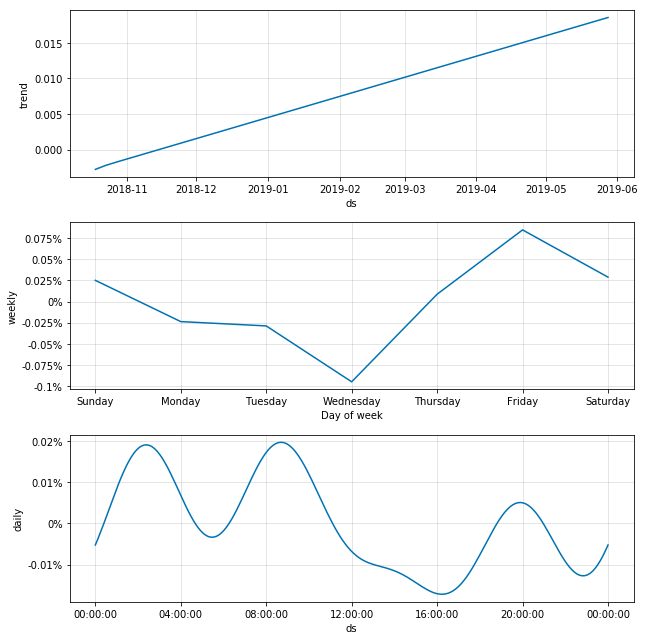

In [52]:
fig2 = prophet.plot_components(forecast,uncertainty=False)

Acceleration

In [53]:
prophet = Prophet(seasonality_mode='multiplicative')
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = x_mean[:,2]

In [54]:
prophet.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [55]:
#Build future, periods set to 30 because there are 30 days of data
future = prophet.make_future_dataframe(periods=180)
#Build Forecast
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1175 2019-05-23 22:45:00 -0.000025   -0.000269    0.000220
1176 2019-05-24 22:45:00 -0.000025   -0.000252    0.000209
1177 2019-05-25 22:45:00 -0.000025   -0.000253    0.000213
1178 2019-05-26 22:45:00 -0.000026   -0.000256    0.000179
1179 2019-05-27 22:45:00 -0.000026   -0.000274    0.000203

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

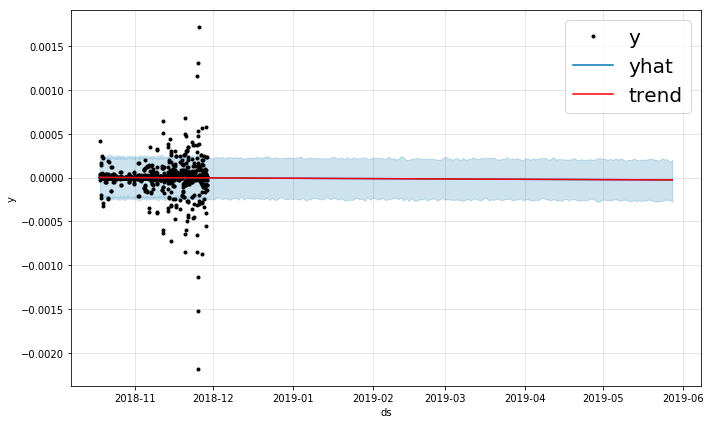

In [56]:
#Build the plot to show the forecasted data
vol = prophet.plot(forecast)
a = add_changepoints_to_plot(vol.gca(), prophet, forecast)
plt.legend(loc='best', fontsize=20)

# Hurst Exponent

In [57]:
def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="BTC",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params,verify=False).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

In [58]:
coin_sym_list = 'EOS'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [59]:
prices.tail()

EOS
time                
2018-11-24  0.000840
2018-11-25  0.000833
2018-11-26  0.000842
2018-11-27  0.000785
2018-11-28  0.000768

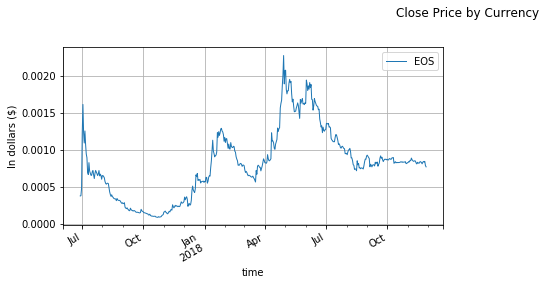

In [60]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [61]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

DSOD        RS       DMA
EOS  0.469067  0.632164  0.498579

In [62]:
# the same methodology as shown in the paper.
roll_days = 250
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

In [63]:
roll_hurst[::50].tail()

EOS          
                DSOD        RS
time                          
2018-03-31  0.450758  0.674113
2018-05-20  0.351438  0.627049
2018-07-09  0.320620  0.639498
2018-08-28  0.297342  0.631056
2018-10-17  0.276208  0.663587

In [64]:
roll_hurst[::50].mean()

EOS  DSOD    0.339273
     RS      0.647061
dtype: float64

In [65]:
roll_hurst[::50].median()

EOS  DSOD    0.320620
     RS      0.639498
dtype: float64

In [66]:
roll_hurst[::50].mean(level=0, axis=1);

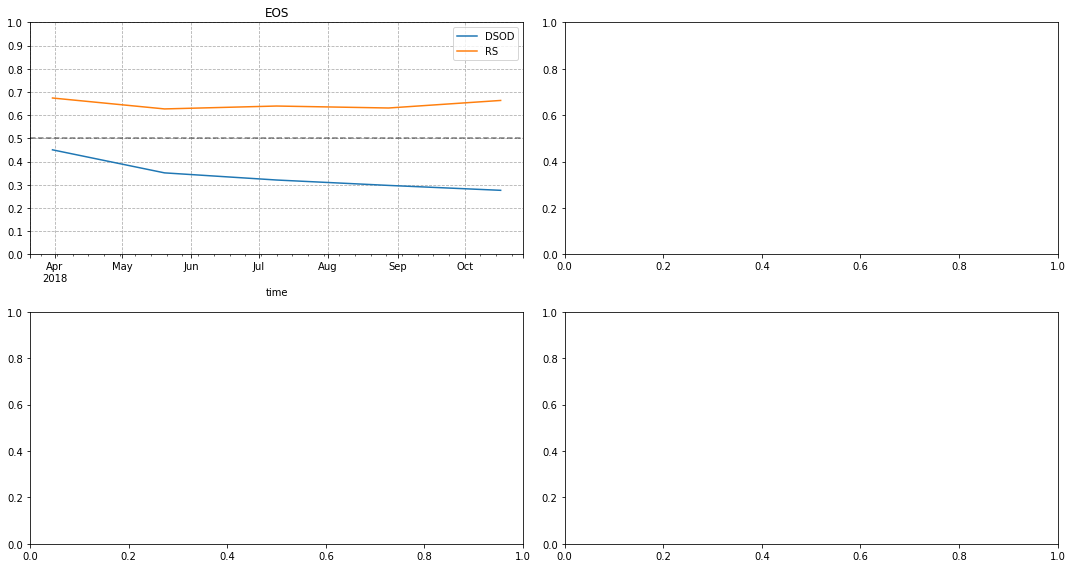

In [67]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [68]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

EOS          
                DSOD        RS
time                          
2018-11-24  0.272918  0.661279
2018-11-25  0.273153  0.661063
2018-11-26  0.273323  0.660722
2018-11-27  0.273578  0.660482
2018-11-28  0.273801  0.659848

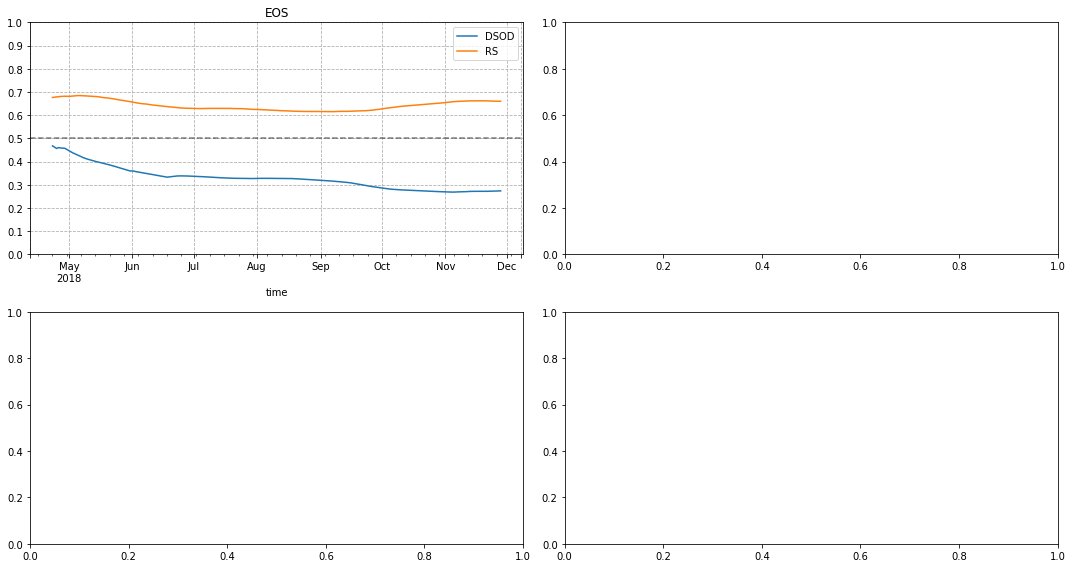

In [69]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [70]:
roll_hurst[::30].tail()

EOS          
                DSOD        RS
time                          
2018-07-09  0.320620  0.639498
2018-08-08  0.335340  0.607610
2018-09-07  0.294731  0.609450
2018-10-07  0.275564  0.666202
2018-11-06  0.270563  0.661345

In [71]:
roll_hurst[::30].mean()

EOS  DSOD    0.354764
     RS      0.651064
dtype: float64

In [72]:
roll_hurst[::30].median()

EOS  DSOD    0.335340
     RS      0.646254
dtype: float64

In [73]:
roll_hurst[::30].mean(level=0, axis=1);

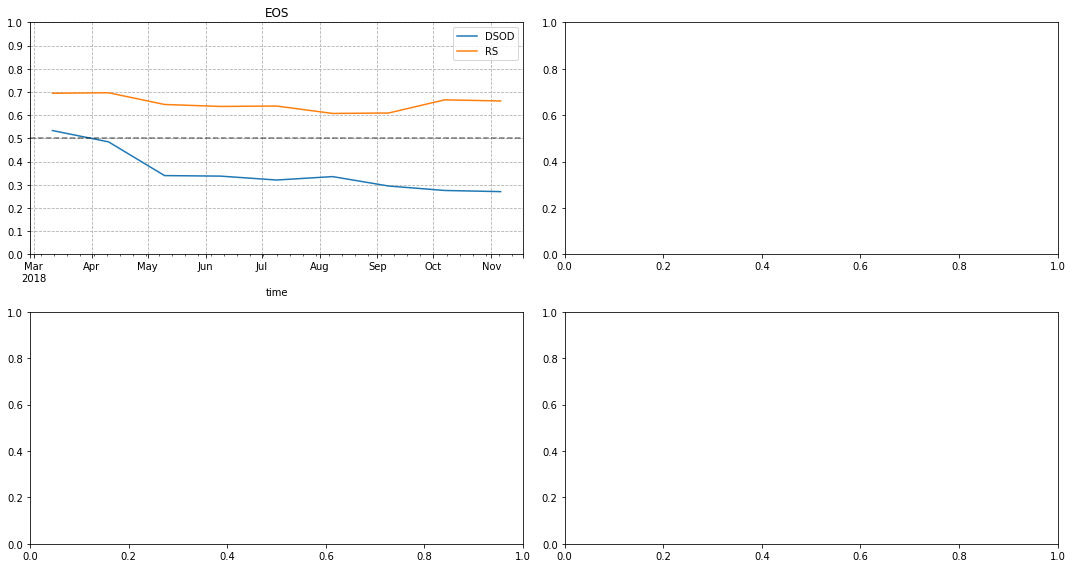

In [74]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [75]:
roll_hurst[::10].tail()

EOS          
                DSOD        RS
time                          
2018-10-17  0.276208  0.663587
2018-10-27  0.274735  0.652710
2018-11-06  0.270563  0.661345
2018-11-16  0.270125  0.668105
2018-11-26  0.284082  0.649179

In [76]:
roll_hurst[::10].mean()

EOS  DSOD    0.335909
     RS      0.647359
dtype: float64

In [77]:
roll_hurst[::10].median()

EOS  DSOD    0.322213
     RS      0.646254
dtype: float64

In [78]:
roll_hurst[::10].mean(level=0, axis=1);

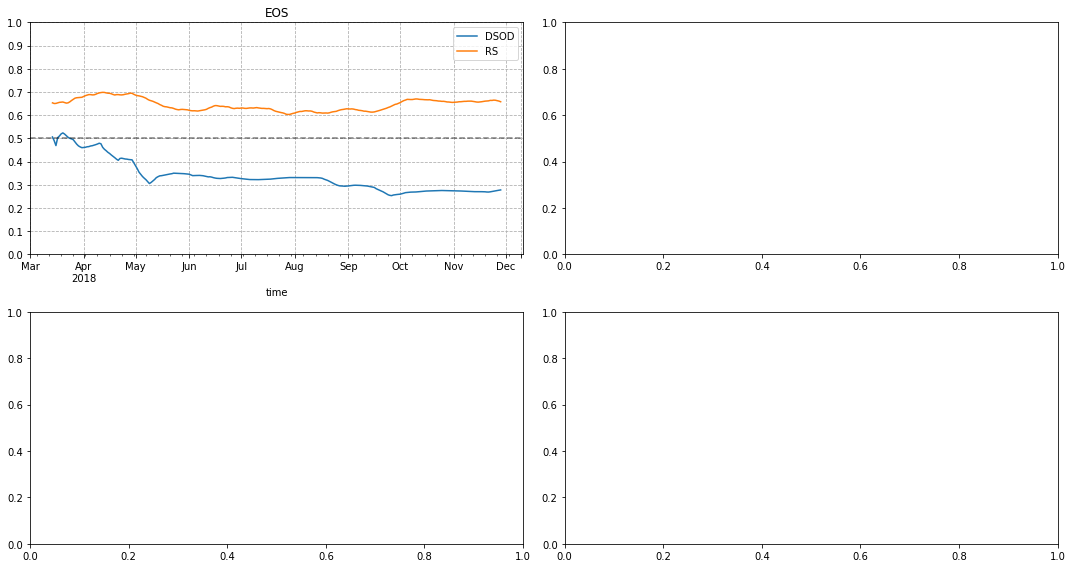

In [79]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# SADF Test

In [80]:
import functools

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller


class SadfTest:
    """ Suppremum-Augmented Dickey Fuller Test
    TODO: Implment quantile and conditional SADF test features described in de Prado.
    Ref: de Prado Section 17.3.2
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    """
    def __init__(self, ticks_required, minimum_sample_length_perc=0.5):
        self.ticks_required = ticks_required
        # out name should uniquely identify the feature with all its args
        self.output_column_names = ['{0}_sadf_test'.format(self.ticks_required)]
        #for ticks in ticks_required:
         #   self.output_column_names.append('{0}_sadf_test'.format(ticks))

        self.minimum_sample_length = int(ticks_required * minimum_sample_length_perc)
    
        assert self.minimum_sample_length <= ticks_required
            
        # TODO: Investigate how the number of lags effects the result
        self.lag_order = 1
        self.minimum_sample_length = int(ticks_required
                                         * minimum_sample_length_perc)
        self.minimum_sample_length = max(self.minimum_sample_length,
                                         self.lag_order + 1)


        def compute_sdaf_stat(x):
            def adf(s_idx):
                # TODO: Investigate the effect of adding time trend to the specification.
                return adfuller(x[s_idx:], maxlag=self.lag_order,
                                autolag=None)[0]
            start_points = range(0, len(x) - self.minimum_sample_length)
            # TODO: This can perhaps be sped up using Pandas expanding windows and apply function.
            return functools.reduce(max, map(adf, start_points))

        buffer = pd.Series(data=np.empty(self.ticks_required))

        def compute_sdaf_stat_vec(x):
            """
            This vectorized version is not faster.
            """
            def adf(y):
                return adfuller(y[::-1],  maxlag=self.lag_order,
                                autolag=None)[0]

            buffer.iloc[:] = x[::-1]
            expanding = buffer.expanding(min_periods=self.minimum_sample_length)
            return expanding.apply(adf).max()

        self.compute_sdaf_stat = compute_sdaf_stat
        # self.compute_sdaf_stat = compute_sdaf_stat_vec


    def generate_bulk(self, reg_ticks: pd.DataFrame):
        log_prices = np.log(reg_ticks['close'])
        rolling = log_prices.rolling(self.ticks_required,
                                     min_periods=self.ticks_required)

        data = (
            rolling.apply(self.compute_sdaf_stat, raw=True)
            .values).astype(np.float)

        return pd.DataFrame(index=reg_ticks.index,
                            data=data,
                            columns=self.output_column_names)


In [81]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = SadfTest(self.features_to_calculate)
        data_df_enriched = data_df.join(feature_generator.generate_bulk(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

    def get_feature_data_log_volume(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = SadfTest(self.features_to_calculate)
        data_df = data_df[data_df['close'] != 0]
        data_df = data_df[data_df['volume'] != 0]
        data_df_enriched = data_df.join(feature_generator.generate_bulk_log_volume(data_df))
#         data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

In [82]:
df = get_ohlcv_poloniex(pair='USDT_EOS', start=0, end=9999999999, period=86400)

In [83]:
df['time'] = pd.to_datetime(df['date'], unit='s')
df.index = df['time']
df.head()

close        date      high       low      open   quoteVolume  \
time                                                                           
2018-07-31  0.000000  1532995200  0.000000  0.000000  0.000000      0.000000   
2018-08-01  7.275186  1533081600  9.990000  6.000000  6.000000  30983.761305   
2018-08-02  7.050000  1533168000  7.348000  6.880599  7.271148  44995.908940   
2018-08-03  7.198887  1533254400  7.250000  6.870239  7.030000  22926.506326   
2018-08-04  6.980326  1533340800  7.296592  6.885000  7.198168  14065.219079   

                   volume  weightedAverage       time  
time                                                   
2018-07-31       0.000000         0.000000 2018-07-31  
2018-08-01  226687.558692         7.316334 2018-08-01  
2018-08-02  321617.223207         7.147699 2018-08-02  
2018-08-03  163288.339843         7.122251 2018-08-03  
2018-08-04   98592.948983         7.009699 2018-08-04

In [84]:
df_prices = df[['close', 'high', 'low', 'open', 'weightedAverage']]
df_volume = (df[['quoteVolume', 'volume']] + 0.001)
log_df = np.log(pd.concat([df_prices, df_volume], axis=1))
log_df.head()

close      high       low      open  weightedAverage  \
time                                                                  
2018-07-31      -inf      -inf      -inf      -inf             -inf   
2018-08-01  1.984469  2.301585  1.791759  1.791759         1.990109   
2018-08-02  1.953028  1.994428  1.928706  1.983914         1.966791   
2018-08-03  1.973926  1.981001  1.927199  1.950187         1.963224   
2018-08-04  1.943096  1.987407  1.929345  1.973826         1.947295   

            quoteVolume     volume  
time                                
2018-07-31    -6.907755  -6.907755  
2018-08-01    10.341219  12.331328  
2018-08-02    10.714327  12.681117  
2018-08-03    10.040049  12.003273  
2018-08-04     9.551460  11.498755

In [85]:
df_daily = df#.resample('D').mean()
df_log_daily = log_df#.resample('D').mean()
df_daily['time'] = pd.to_datetime(df_daily.index)
df_log_daily['time'] = pd.to_datetime(df_log_daily.index)

In [86]:
df_daily.head()

close        date      high       low      open   quoteVolume  \
time                                                                           
2018-07-31  0.000000  1532995200  0.000000  0.000000  0.000000      0.000000   
2018-08-01  7.275186  1533081600  9.990000  6.000000  6.000000  30983.761305   
2018-08-02  7.050000  1533168000  7.348000  6.880599  7.271148  44995.908940   
2018-08-03  7.198887  1533254400  7.250000  6.870239  7.030000  22926.506326   
2018-08-04  6.980326  1533340800  7.296592  6.885000  7.198168  14065.219079   

                   volume  weightedAverage       time  
time                                                   
2018-07-31       0.000000         0.000000 2018-07-31  
2018-08-01  226687.558692         7.316334 2018-08-01  
2018-08-02  321617.223207         7.147699 2018-08-02  
2018-08-03  163288.339843         7.122251 2018-08-03  
2018-08-04   98592.948983         7.009699 2018-08-04

In [87]:
features = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
for item in features:
    sadf_features = StructuralBreakFeatures(
    features_to_calculate=item)

In [88]:
sadf_enriched1024 = sadf_features.get_feature_data(df_daily)
print(sadf_enriched1024.tail(2))

               close        date      high       low      open   quoteVolume  \
time                                                                           
2018-11-27  3.077633  1543276800  3.248470  2.869844  3.248360  83159.127630   
2018-11-28  3.289091  1543363200  3.369718  3.056903  3.076277  63208.026518   

                   volume  weightedAverage       time  1024_sadf_test  
time                                                                   
2018-11-27  252845.863984         3.040506 2018-11-27             NaN  
2018-11-28  203291.306527         3.216226 2018-11-28             NaN  


In [89]:
sadf_enriched1024.describe()

close          date        high         low        open  \
count  121.000000  1.210000e+02  121.000000  121.000000  121.000000   
mean     5.302532  1.538179e+09    5.513104    5.103988    5.325247   
std      0.934041  3.030370e+06    1.010471    0.912031    0.916857   
min      0.000000  1.532995e+09    0.000000    0.000000    0.000000   
25%      4.994988  1.535587e+09    5.193084    4.773474    4.968691   
50%      5.419142  1.538179e+09    5.511122    5.231742    5.430798   
75%      5.721566  1.540771e+09    5.900000    5.500000    5.735466   
max      7.275186  1.543363e+09    9.990000    6.930000    7.271148   

         quoteVolume        volume  weightedAverage  1024_sadf_test  
count     121.000000  1.210000e+02       121.000000             0.0  
mean    47846.023390  2.489601e+05         5.292343             NaN  
std     46096.134373  2.479164e+05         0.933079             NaN  
min         0.000000  0.000000e+00         0.000000             NaN  
25%     14065.219079  7.953506e+04         4.987995             NaN  
50%     34052.844178  1.710878e+05         5.397182             NaN  
75%     71937.343867  3.524434e+05         5.693156             NaN  
max    238605.848416  1.464057e+06         7.316334             NaN

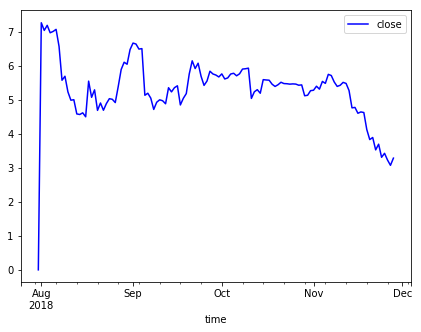

In [90]:
#for feature in features:
fig, ax = plt.subplots(figsize=(7,5))
sadf_enriched1024['close'].plot(ax=ax, style='b-', legend=True)

# Heirarchal Clustering

In [91]:
%matplotlib inline
import sys
import errno
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from matplotlib import figure
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_pacf
from collections import OrderedDict
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [92]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [93]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

In [94]:
plt.rcParams['figure.figsize'] = [11,6]

In [95]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='USDT_BTC', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [96]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [97]:
def get_pairs():
    for pair in ['USDT_EOS','BTC_EOS']:
        timeSeries = pd.DataFrame()
        df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
        df = df[df.index % 7 == 0]
        df['pct_change'] = df['weightedAverage'].pct_change()
        df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
        df[pair] = df['log_ret']
        df = pd.DataFrame(df[pair])
        timeSeries = pd.concat([timeSeries,df], axis=1)
        timeSeries = timeSeries.iloc[1:]
        yield timeSeries, pair

In [98]:
def generate_clusters(timeSeries, pair):
    z_euclidean = hac.linkage(timeSeries, method='average', metric='euclidean'),"Euclidean"
    z_minkowski = hac.linkage(timeSeries, method='average', metric='minkowski'),"Minowski"
    z_cityblock = hac.linkage(timeSeries, method='average', metric='cityblock'),"Cityblock"
    z_cosine = hac.linkage(timeSeries, method='average', metric='cosine'),"Cosine"
#    z_correlation = hac.linkage(timeSeries, method='average', metric='correlation'),"Correlation"

    p = 12
    max_d = 50
    
    for z, name in [z_euclidean,z_minkowski,z_cityblock,z_cosine]:#,z_correlation]: 
                                #ValueError: Method 'ward' requires the distance metric to be Euclidean
        print(pair)
        print(name, "/", "Avg")
        fancy_dendrogram(
            z,
            truncate_mode='lastp',
            p=p,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,  # useful in small plots so annotations don't overlap
            max_d=max_d,
        )
        plt.show()
        
        c, coph_dists = cophenet(z, pdist(timeSeries))
        print(name + " Cophenetic Correlation Coefficient: " + str(c))

        print("Euclidean Clusters")
        clusters = fcluster(z, max_d, criterion='distance')
#         plt.figure(figsize=(10, 8))
        ar = np.arange(len(timeSeries))
        plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
        plt.show()

In [99]:
def plot_partial_lag(timeSeries, lag):
    plot_pacf(timeSeries, lags=lag)
    plt.show()    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



USDT_EOS
Euclidean / Avg
Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

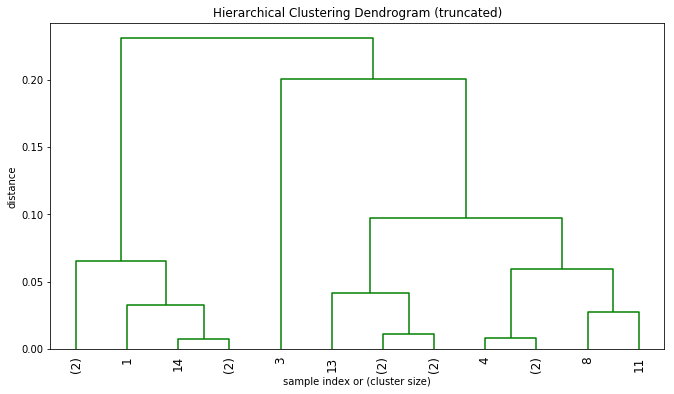

Euclidean Cophenetic Correlation Coefficient: 0.8079282857373999
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

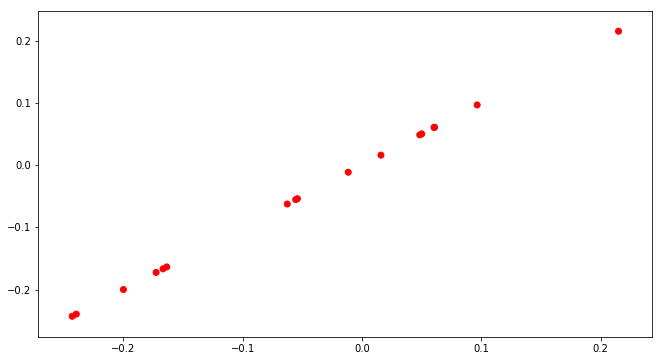

USDT_EOS
Minowski / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

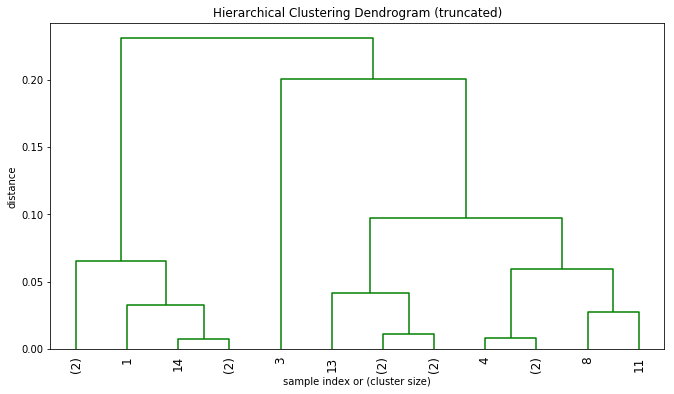

Minowski Cophenetic Correlation Coefficient: 0.8079282857373999
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

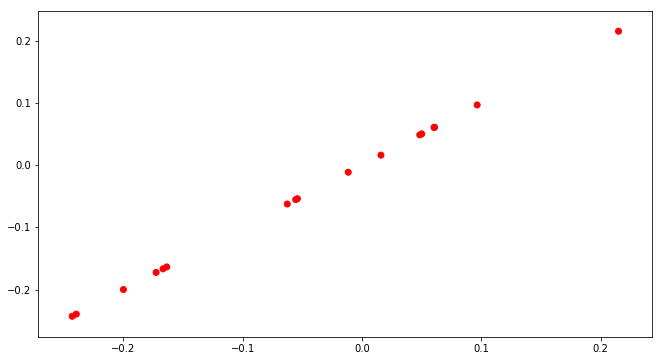

USDT_EOS
Cityblock / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

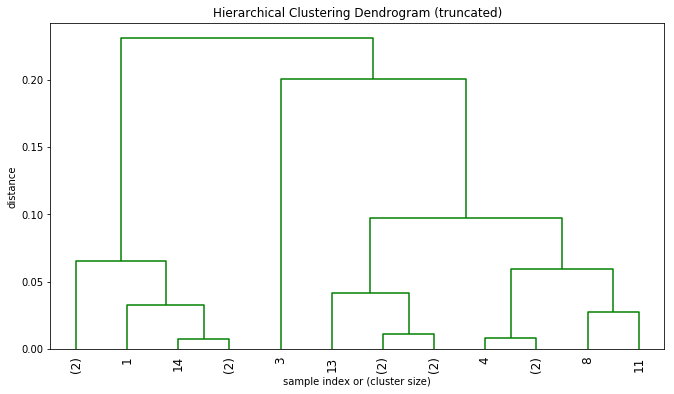

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Cityblock Cophenetic Correlation Coefficient: 0.8079282857373999
Euclidean Clusters
Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

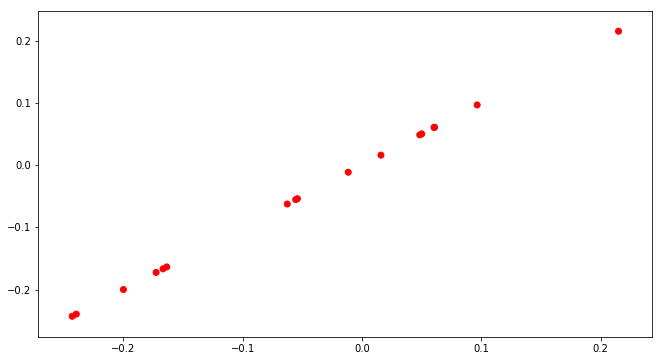

USDT_EOS
Cosine / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

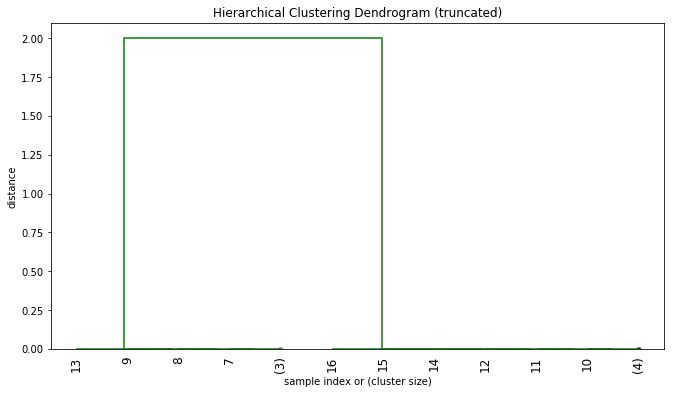

Cosine Cophenetic Correlation Coefficient: 0.5958686300387077
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

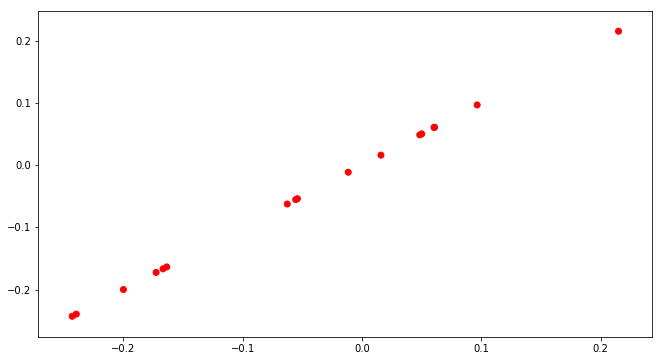

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

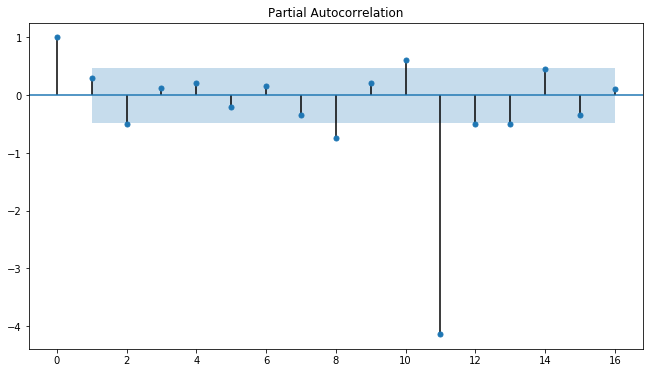

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



BTC_EOS
Euclidean / Avg
Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

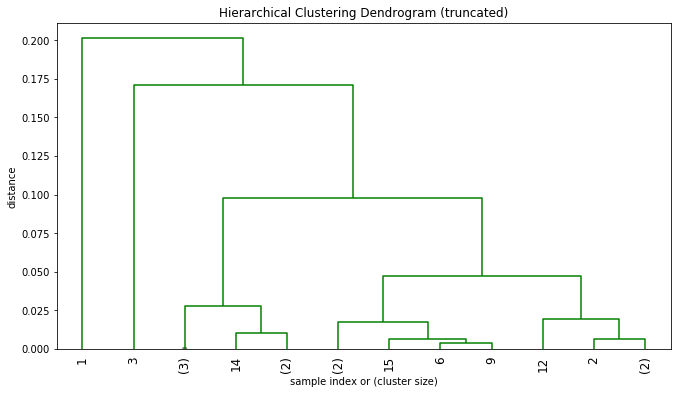

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Euclidean Cophenetic Correlation Coefficient: 0.8734139949929914
Euclidean Clusters
Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

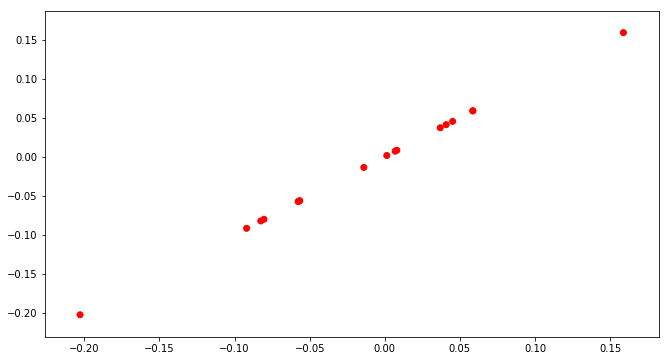

BTC_EOS
Minowski / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

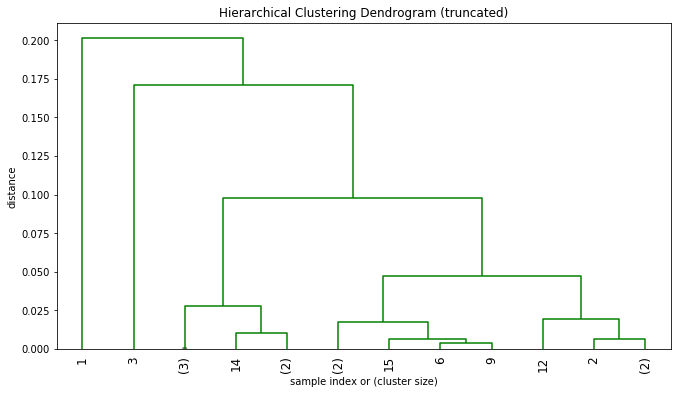

Minowski Cophenetic Correlation Coefficient: 0.8734139949929914
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

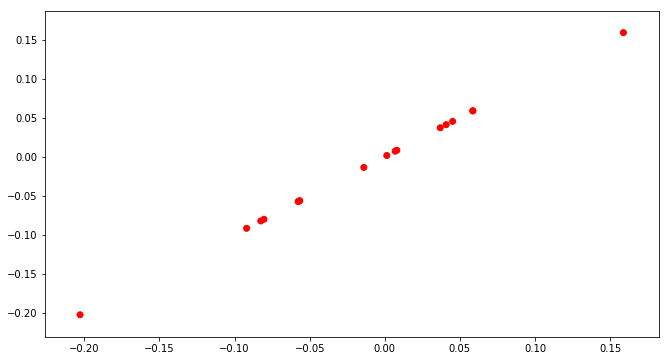

BTC_EOS
Cityblock / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

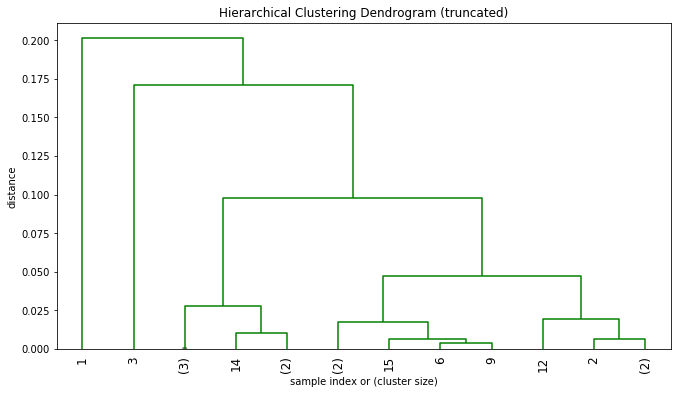

Cityblock Cophenetic Correlation Coefficient: 0.8734139949929914
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

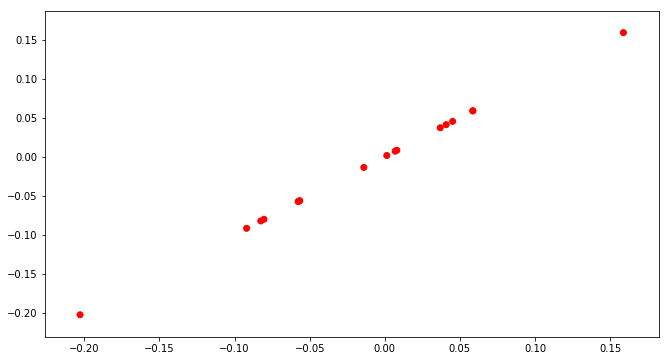

BTC_EOS
Cosine / Avg


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

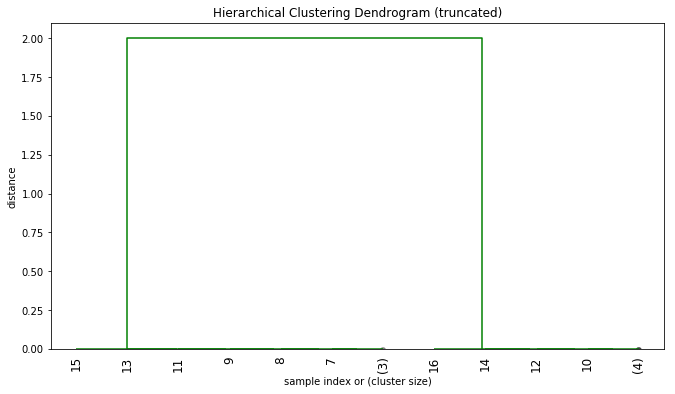

Cosine Cophenetic Correlation Coefficient: 0.5223341703984706
Euclidean Clusters


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

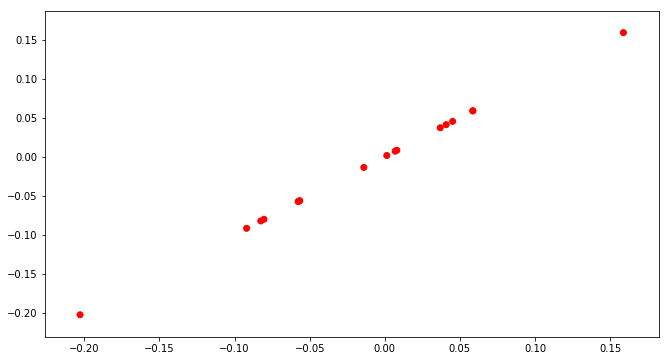

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

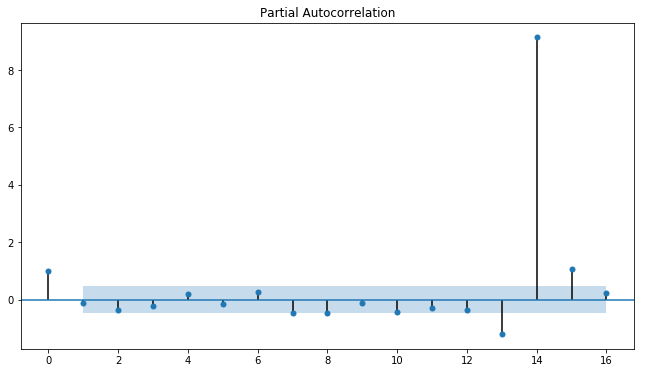

In [100]:
for series, pair in get_pairs():
    generate_clusters(series, pair)
    plot_partial_lag(series, 50)

# Commits/Issues/PR/STAR Analysis

In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf
from collections import OrderedDict

In [102]:
def plot_partial_lag(timeSeries, lag, coin):
    plot_pacf(timeSeries, lags=lag)
    rcParams['figure.figsize'] = 6,6
    plt.title(coin, fontsize=30)
    plt.show()    

In [103]:
frames = {}
path = 'Desktop/github_data/'
for filename in os.listdir(path):
    if filename == "EOS.csv":
        coin = filename.split('.')[0]
        frames[coin] = pd.read_csv(path + filename)

In [104]:
baseDate = datetime.datetime(2017, 6, 1)
date_list = [baseDate - datetime.timedelta(days=x) for x in range(0, 265)]
for coin, df in frames.items():
    frames[coin]['ds'] = [np.datetime64('2017-06-01') + np.timedelta64(num_dates,'D') for num_dates in range(len(frames[coin]))]

In [105]:
frames = OrderedDict(sorted(frames.items(), key=lambda x: x[1]['commit_add_sum'].sum(), reverse=True))

return Percent

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

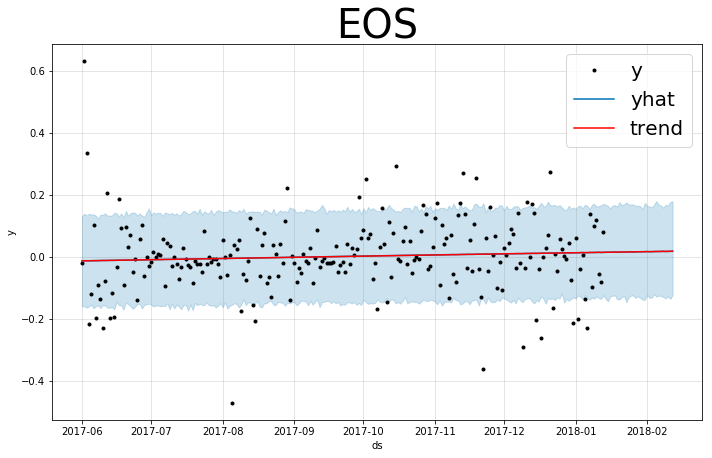

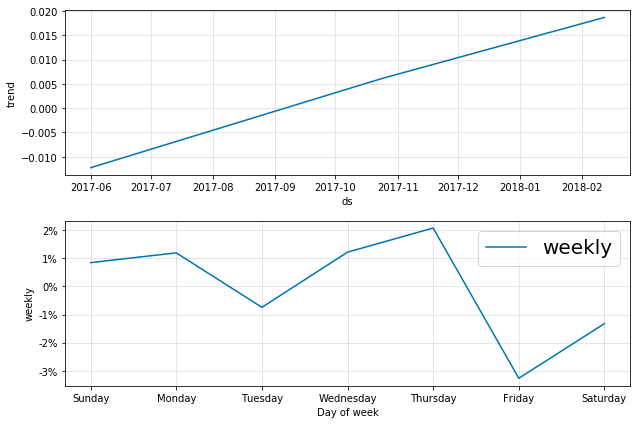

In [106]:
for coin, df in frames.items():
    df['y'] = (df.close - df.open) / df.close
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

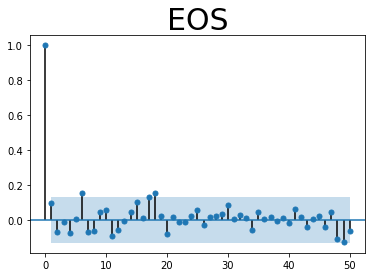

In [107]:
for coin, df in frames.items():
    plot_partial_lag((df.close - df.open) / df.close, 50, coin)

commit add sum

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

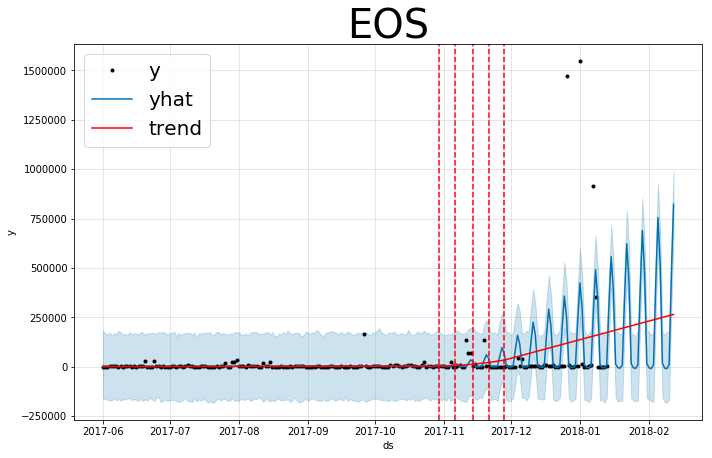

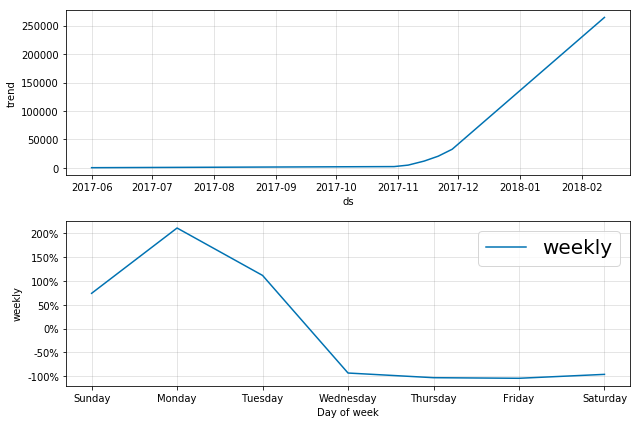

In [108]:
for coin, df in frames.items():
    df['y'] = df['commit_add_sum']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

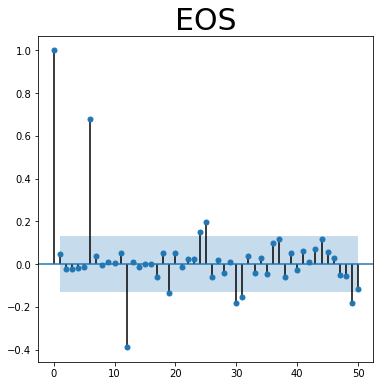

In [109]:
for coin, df in frames.items():
    df['commit_add_sum'] = df['commit_add_sum'] + .01
    
for coin, df in frames.items():
    plot_partial_lag(df['commit_add_sum'], 50, coin)

Commit Count

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

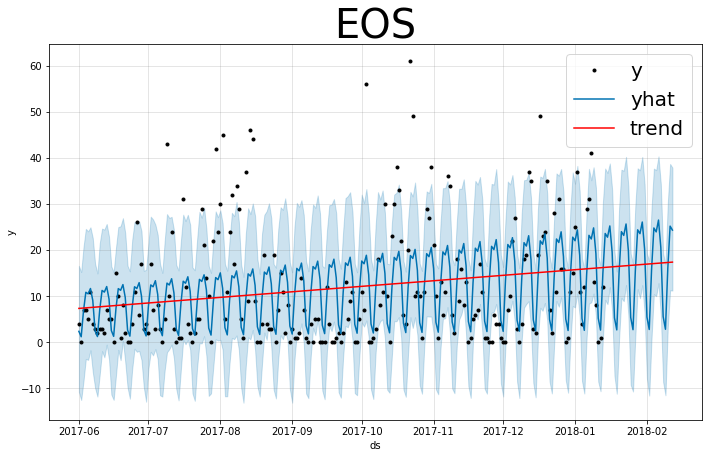

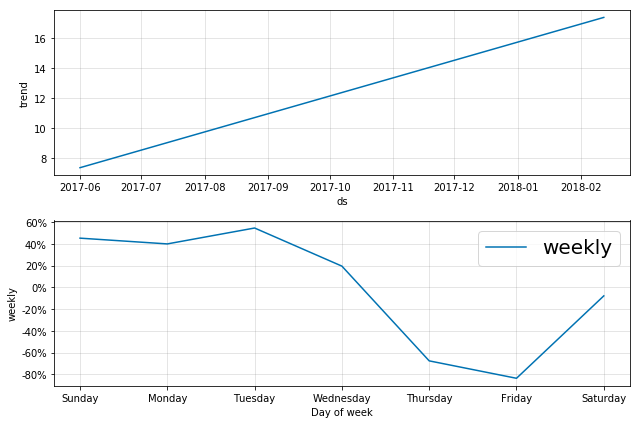

In [110]:
for coin, df in frames.items():
    df['y'] = df['commit_count']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

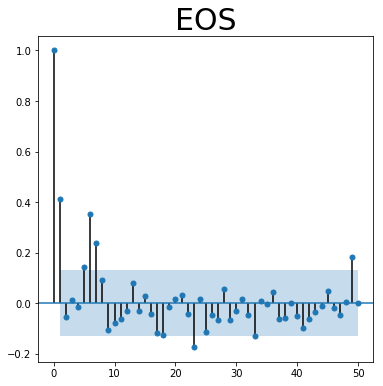

In [111]:
for coin, df in frames.items():
    df['commit_count'] += .01
    
for coin, df in frames.items():
    plot_partial_lag(df['commit_count'], 50, coin)

Commit Del Sum

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

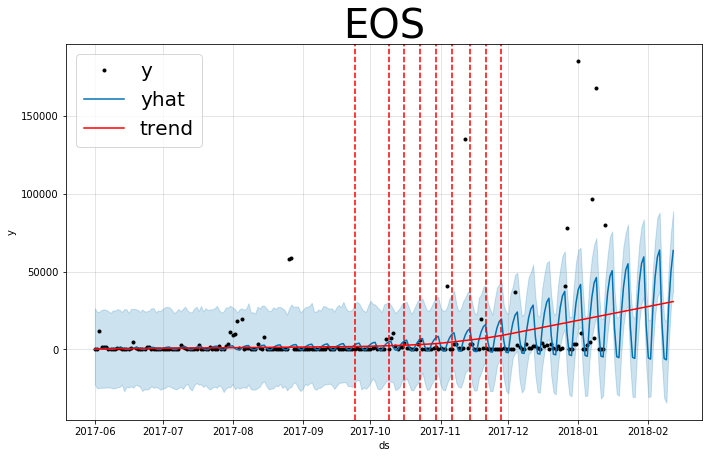

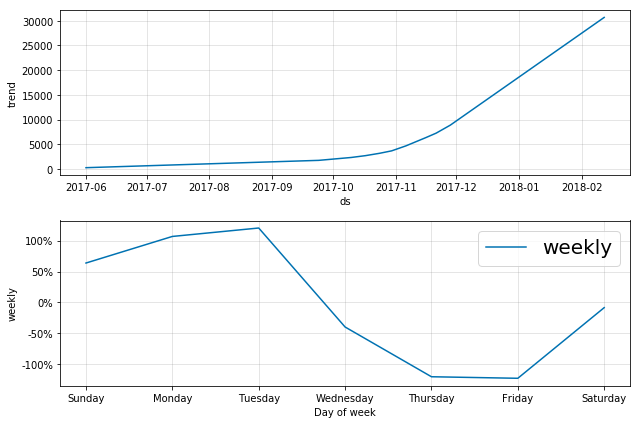

In [112]:
for coin, df in frames.items():
    df['y'] = df['commit_del_sum']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

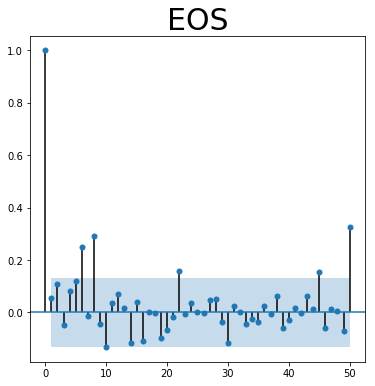

In [113]:
for coin, df in frames.items():
    df['commit_del_sum'] += .01
    
for coin, df in frames.items():
    plot_partial_lag(df['commit_del_sum'], 50, coin)

Issues Count

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

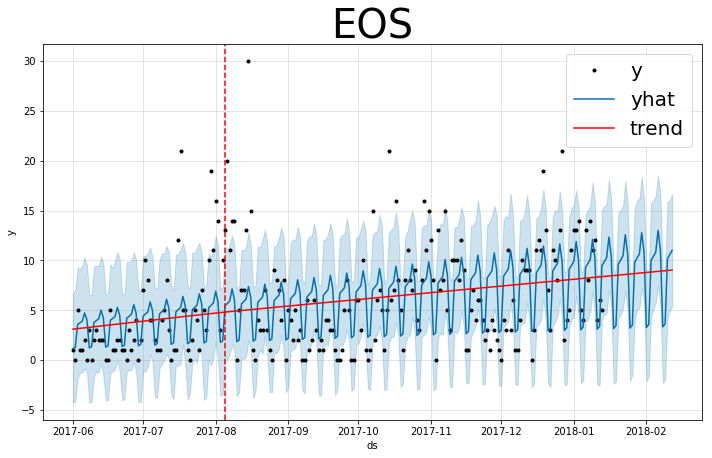

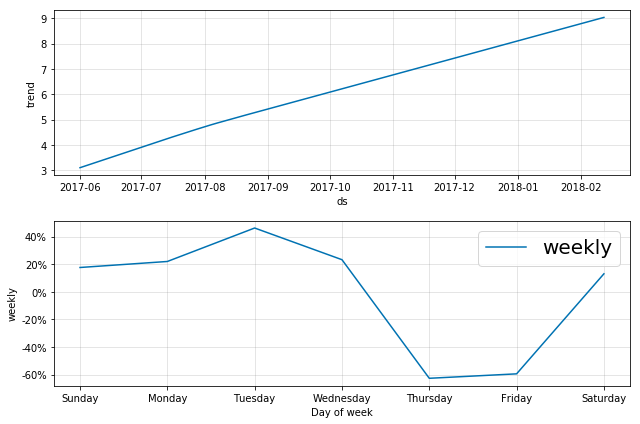

In [114]:
for coin, df in frames.items():
    df['y'] = df['issues_count']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

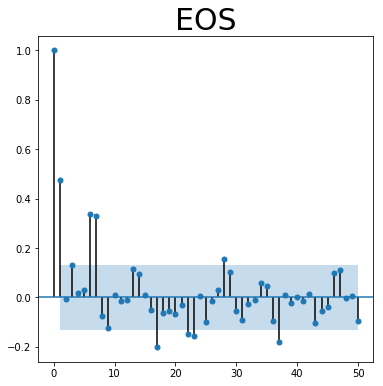

In [115]:
for coin, df in frames.items():
    df['issues_count'] += .01
    
for coin, df in frames.items():
    plot_partial_lag(df['issues_count'], 50, coin)

PR Count

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

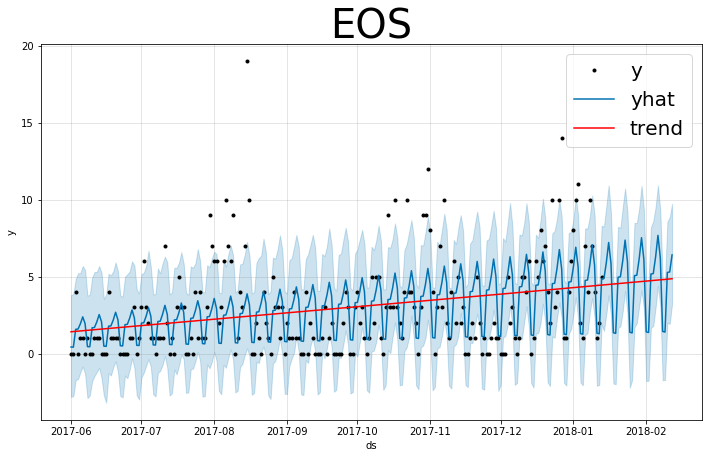

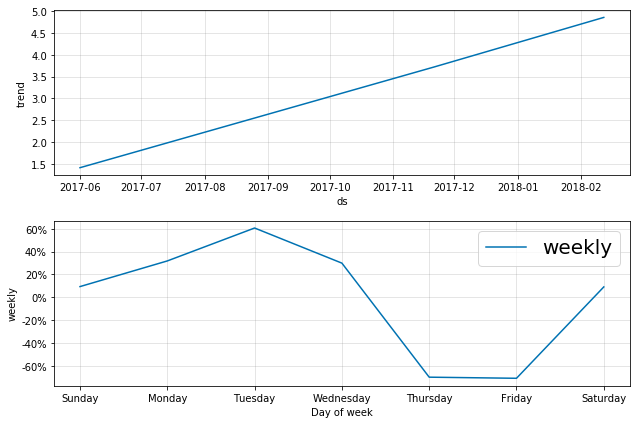

In [116]:
for coin, df in frames.items():
    df['y'] = df['pr_count']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

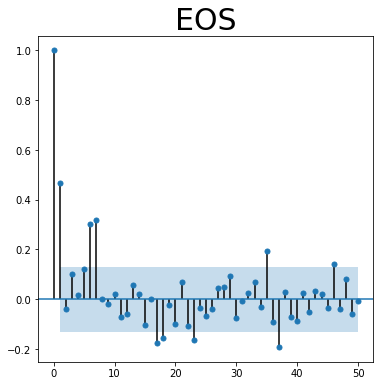

In [117]:
for coin, df in frames.items():
    df['pr_count'] += .01
    
for coin, df in frames.items():
    plot_partial_lag(df['pr_count'], 50, coin)

Star Count

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

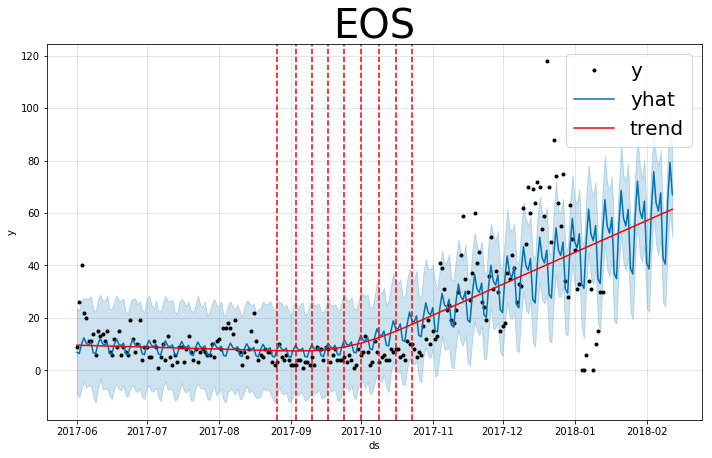

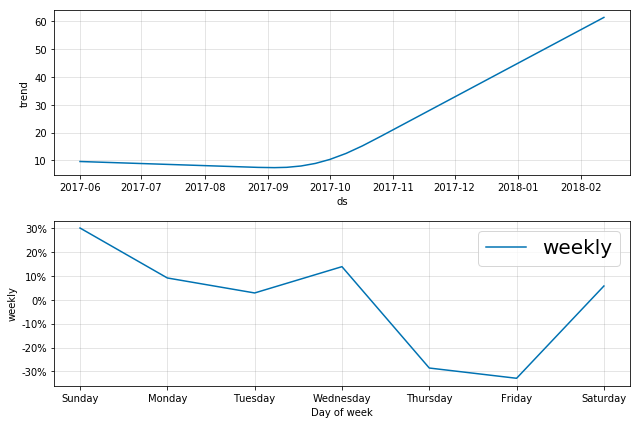

In [118]:
for coin, df in frames.items():
    df['y'] = df['star_count']
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

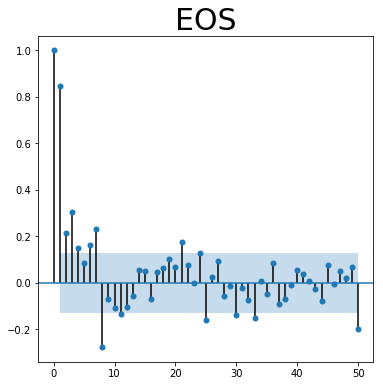

In [119]:
for coin, df in frames.items():
    df['star_count'] += .01
    
for coin, df in frames.items():
    plot_partial_lag(df['star_count'], 50, coin)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

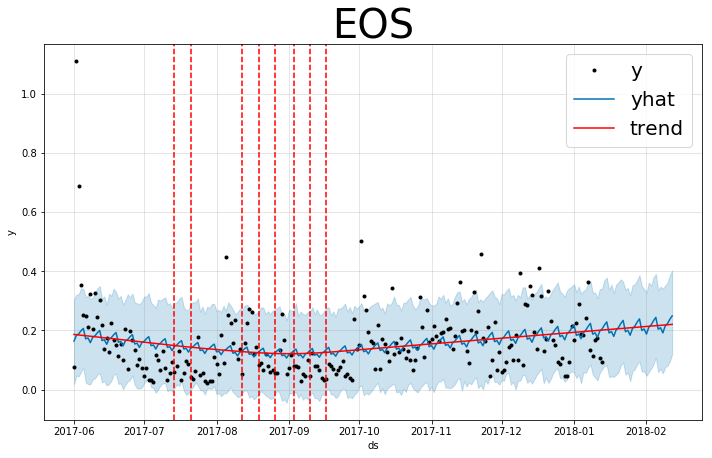

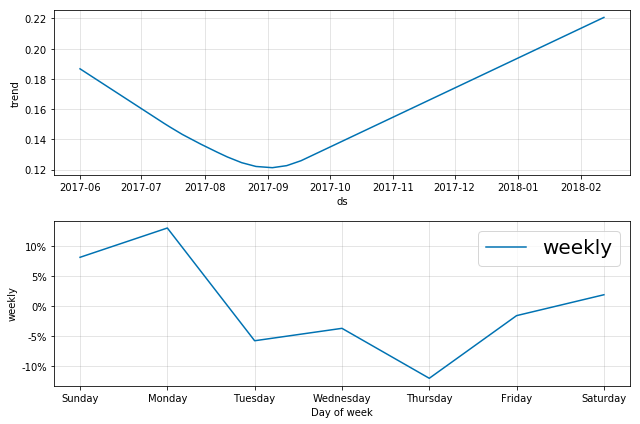

In [120]:
for coin, df in frames.items():
    df['y'] = (df.high - df.low) / ((df.high + df.low) / 2)
    
    prophet = Prophet(seasonality_mode='multiplicative')
    prophet.fit(df)
    
    #Build future, periods set to 30 because there are 30 days of data
    future = prophet.make_future_dataframe(periods=30)
    #Build Forecast
    forecast = prophet.predict(future)
    
    
    x = prophet.plot(forecast)
    a = add_changepoints_to_plot(x.gca(), prophet, forecast)
    plt.title(coin, fontsize=40)
    plt.legend(loc='best', fontsize=20)
    
    fig2 = prophet.plot_components(forecast,uncertainty=False)
    plt.legend(loc='best', fontsize=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
TypeError: Object of type 'ndarray' is not JSON serializable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: Object of type 'ndarray' is not JSON serializable

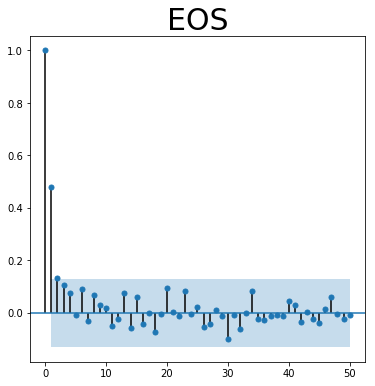

In [121]:
for coin, df in frames.items():
    plot_partial_lag((df.high - df.low) / ((df.high + df.low) / 2),50,coin)

# Entropy

In [122]:
class QuantileEncoder:
    """
    Performs quantile encoding for a real valued source.  The assigned value
    for each bins is chosen as to minimize the mean square error introduced
    by the quantization (conditional expectation within the bin).
    Quantizer bins and mappings are computed from the empirical distribution
    of the training data.
    """
    def __init__(self, alphabet_size=2):
        assert alphabet_size >= 2

        self._quantiles = [n / float(alphabet_size)
                           for n in range(alphabet_size + 1)]
        self._bins = None
        self._bin_mappings = None
        self._suffix = '_right'

    def fit(self, data: pd.Series):
        """
        Fit the quantizer parameters from training data.
        :param data:
        :return:
        """
        self.fit_transform(data)

    def transform(self, data: pd.Series):
        """
        Previously fit encoder performs the transformation on new data.
        :param data:
        :return:
        """
        assert self._bins is not None
        assert self._bin_mappings is not None

        ser = pd.cut(data, self._bins, labels=False)
        ser.name = 'labels'

        df = pd.concat([ser, data], axis=1)
        df_joined = df.join(self._bin_mappings, 'labels', rsuffix=self._suffix)

        return df_joined[data.name + self._suffix]

    def fit_transform(self, data: pd.Series):
        """
        Train with then return the transformation of some data.
        :param data:
        :return:
        """
        ser, bins = pd.qcut(data, self._quantiles, retbins=True, labels=False)
        ser.name = 'labels'

        df = pd.concat([ser, data], axis=1)
        bin_mappings = df.groupby('labels').mean()
        df_joined = df.join(bin_mappings, 'labels', rsuffix=self._suffix)

        self._bins = bins
        self._bin_mappings = bin_mappings

        return df_joined[data.name + self._suffix]

In [123]:
def plugIn(msg, w):
    # Compute plug-in (ML) entropy rate
    pmf = pmf1(msg, w)
    out = - sum([pmf[i] * np.log2(pmf[i]) for i in pmf]) / w
    return out, pmf

def pmf1(msg, w):
    # Compute the prob mass function for a 1D discrete RV
    # len(msg)-w occurances
    lib = {}
    if not isinstance(msg, str): msg = ''.join(map(str, msg))
    for i in range(w, len(msg)):
        msg_ = msg[i-w: i]
        if msg_ not in lib: 
            lib[msg_] = [i-w]
        else: 
            lib[msg_] = lib[msg_] + [i-w]
    pmf = float(len(msg) - w)
    pmf = {i: len(lib[i])/pmf for i in lib}
    return pmf

In [124]:
class EntropyEstimatorLz:
    """
    Kontoyiannis' LZ entropy estimate, 2013 version (centered window). Inverse
    of the avg length of the shortest non-redundant substring. If non-redundant
    substrings are short, the text is highly entropic. window==None for
    expanding window, in which case
    len(msg) % 2 == 0
    If the end of msg is more relevant, try estimate_entropy(msg[::-1])
    """
    @classmethod
    def estimate_entropy(cls, *args, **kwargs):
        return cls.konto(*args, **kwargs)['h']

    @classmethod
    def konto(cls, msg, window=None):
        """
        :param msg:
        :param window:
        :return:
        """
        out = {'num': 0, 'sum': 0, 'sub_str': []}
        if not isinstance(msg, str):
            msg = ''.join(map(str, msg))

        if window is None:
            points = range(1, len(msg) // 2 + 1)

        else:
            window = min(window, len(msg) // 2)
            points = range(window, len(msg) - window + 1)

        for i in points:
            if window is None:
                l, msg_ = cls.match_length(msg, i, i)
                out['sum'] += math.log2(i + 1) / l

            else:
                l, msg_ = cls.match_length(msg, i, window)
                out['sum'] += math.log2(window + 1) / l

            out['sub_str'].append(msg_)
            out['num'] += 1

        out['h'] = (out['sum'] / out['num']) / math.log(2)
        out['r'] = 1 - out['h'] / math.log2(len(msg))  # redundancy, 0 <= r <= 1

        return out

    @staticmethod
    def match_length(msg, i, n):
        """
        Maximum matched length + 1, with overlap.
        i >= n & len(msg) >= i + n
        :param msg:
        :param i:
        :param n:
        :return:
        """
        sub_str = ''
        for l in range(n):
            msg1 = msg[i:i + l + 1]

            for j in range(i - n, i):
                msg0 = msg[j:j + l + 1]

                if msg1 == msg0:
                    sub_str = msg1
                    break  # search for higher l.

        return len(sub_str) + 1, sub_str  # matched length + 1


if __name__ == '__main__':
    # Messages produces entropies of 0.97 and 0.84 as highlighted in
    # "Advances in Financial Machine Learning" section 18.4
    for m in ('11100001', '01100001'):
        h = EntropyEstimatorLz.estimate_entropy(m) * math.log(2)
print('message: %s, entropy: %.2f' % (m, h))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
NameError: name 'math' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


NameError: name 'math' is not defined

In [125]:
def segment(total):
    current_seg = []
    len_seg = len(total)//1000
    for item in total:
        if len(current_seg) < len_seg:
            current_seg.append(item)
            continue
        yield current_seg
        current_seg = []

In [126]:
df = get_ohlcv_poloniex(pair='USDT_EOS', start=0, end=9999999999, period=900)
#df['sumVolume'] = 0
sumVolume = 0
volumeBars = pd.DataFrame()
for i, row in df.iterrows():
    sumVolume += row['quoteVolume']
    if sumVolume >= 100:
        volumeBars = volumeBars.append(row)
        sumVolume = 0

In [127]:
volumeBars['ret'] = volumeBars['weightedAverage'].pct_change()
volumeBars = volumeBars[volumeBars['ret'] != 0]
volumeBars = volumeBars[volumeBars['ret'] != np.inf]
volumeBars = volumeBars[volumeBars['ret'].notnull()]
volumeBars['binary'] = volumeBars.apply(lambda row: int(row['ret']*(row['ret']-1) > 0), axis = 1)

In [128]:
partitions = segment(volumeBars['binary'])
num_segments = len(volumeBars['binary'])//1000
print(num_segments)

4


In [129]:
results = pd.DataFrame()
results['plug-in'] = [plugIn(part, 10)[0] for part in partitions]

In [130]:
partitions = segment(volumeBars['binary'])
# for part in partitions:
#     print(part)
#     print("binary: " + str(EntropyEstimatorLz.estimate_entropy(part, window=100)))
results['kontoyiannis'] = [EntropyEstimatorLz.estimate_entropy(part, window=100) for part in partitions]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
NameError: name 'math' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


NameError: name 'math' is not defined

In [ ]:
print(results['kontoyiannis'].corr(results['plug-in']))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
KeyError: 'kontoyiannis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
KeyError: 'kontoyiannis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError
Traceback (most recent call last):
KeyError: 'kontoyiannis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
KeyError: 'kontoyiannis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
TypeError: must be str, not list

During 

# Google Trends

In [131]:
path = 'downloads/gtrends_data/'
for filename in os.listdir(path):
    if filename.startswith('eos'):
        df = pd.read_csv(path + filename, names=['ds','y'])
        df['y'] = df['y'].replace({"<1": "0"})
        df = df.iloc[3:]
        m = Prophet()
        m.fit(df)
        future = m.make_future_dataframe(periods=1)
        future.tail()
        forecast = m.predict(future)
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
        fig1 = m.plot(forecast)
        fig2 = m.plot_components(forecast)

ERROR! Session/line number was not unique in database. History logging moved to new session 138
